![](https://d1vwxdpzbgdqj.cloudfront.net/s3-public-images/learning-partners/greatlearning-brand.png)

# Introduction to Logistic Regression
> Agenda:
    
> <font color='blue'>1) Read iris dataset and create exploratory plots</font>

> <font color='blue'>2) Split dataset into train/test for cross validation</font>

> <font color='blue'>3) Fit a binary logistic regression</font>

> $log_{b} \frac{p}{(1 - p)}$ Setosa = $\beta_{0}$ + $\beta_{1}$ $SepalLength_{i}$ + $\epsilon_{i}$

> <font color='blue'>4) Assess prediction accuracy on test set</font>

> <font color='blue'>5) Prove your theoretical understanding - predict using only the coefficients</font>

### Configuration & Module Imports

In [1]:
from IPython.display import HTML
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
import seaborn as sns
from sklearn import datasets
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
warnings.filterwarnings('ignore')

# Taken from https://stackoverflow.com/questions/31517194/how-to-hide-one-specific-cell-input-or-output-in-ipython-notebook
tag = HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To show/hide this cell's raw code input, click <a href="javascript:code_toggle()">here</a>.''')
display(tag)

### User Defined Functions
#### <font color='orange'>(already done for you)</font>

In [2]:
def read_reformat_iris_data(numeric_cols = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width',
                                            'iris_type_setosa', 'iris_type_versicolor', 'iris_type_virginica']):
    """
    Reads sklearn iris dataset, reformatting utils.Bunch object into digestable pandas.DataFrame
    Args:
        numeric_cols (list): list of field names to convert to numeric in returned DataFrame
    Returns:
        pandas.DataFrame object with fields:
            >> 'sepal_length'
            >> 'sepal_width'
            >> 'petal_length'
            >> 'petal_width'
            >> 'iris_type'
            >> 'iris_type_setosa'
            >> 'iris_type_versicolor'
            >> 'iris_type_virginica'
    """
    iris = datasets.load_iris()
    iris_df = pd.DataFrame(iris['data'], columns = [s.replace(' (cm)', '').replace(' ', '_') for s in iris['feature_names']])
    target_dict = dict(zip([0,1,2], list(iris['target_names'])))
    iris_df['iris_type'] = [target_dict.get(x) for x in iris['target']]
    iris_df['iris_type_setosa'] = [1 if x == 'setosa' else 0 for x in iris_df['iris_type']]
    iris_df['iris_type_versicolor'] = [1 if x == 'versicolor' else 0 for x in iris_df['iris_type']]
    iris_df['iris_type_virginica'] = [1 if x == 'virginica' else 0 for x in iris_df['iris_type']]
    iris_df[numeric_cols] = iris_df[numeric_cols].apply(pd.to_numeric)
    return iris_df


def extract_logreg_coefficients(logit_model):
    """
    Extract coefficients from fitted statsmodel.Logit() object
    Args:
        logit_model (statsmodel.Logit): fitted model object
    Returns:
        dictionary with variable names as keys and coefficients as elements
    """
    coef_table = pd.read_html(logit_model.summary().tables[1].as_html(),header=0,index_col=0)[0]['coef']
    return dict(zip(coef_table.index, coef_table.values))


display(tag)

# <font color='blue'>1) Read iris dataset and create exploratory plots</font>

### Read Iris Dataset
#### <font color='orange'>(already done for you)</font>
![](https://s3.amazonaws.com/assets.datacamp.com/blog_assets/Machine+Learning+R/iris-machinelearning.png)

In [3]:
iris_df = read_reformat_iris_data()

### Look at first 5 rows from iris_df

In [4]:
iris_df.head()

,sepal_length,sepal_width,petal_length,petal_width,iris_type,iris_type_setosa,iris_type_versicolor,iris_type_virginica
0,5.1,3.5,1.4,0.2,setosa,1,0,0
1,4.9,3.0,1.4,0.2,setosa,1,0,0
2,4.7,3.2,1.3,0.2,setosa,1,0,0
3,4.6,3.1,1.5,0.2,setosa,1,0,0
4,5.0,3.6,1.4,0.2,setosa,1,0,0


### Use a pair plot from the seaborn module to quickly visualize relationships

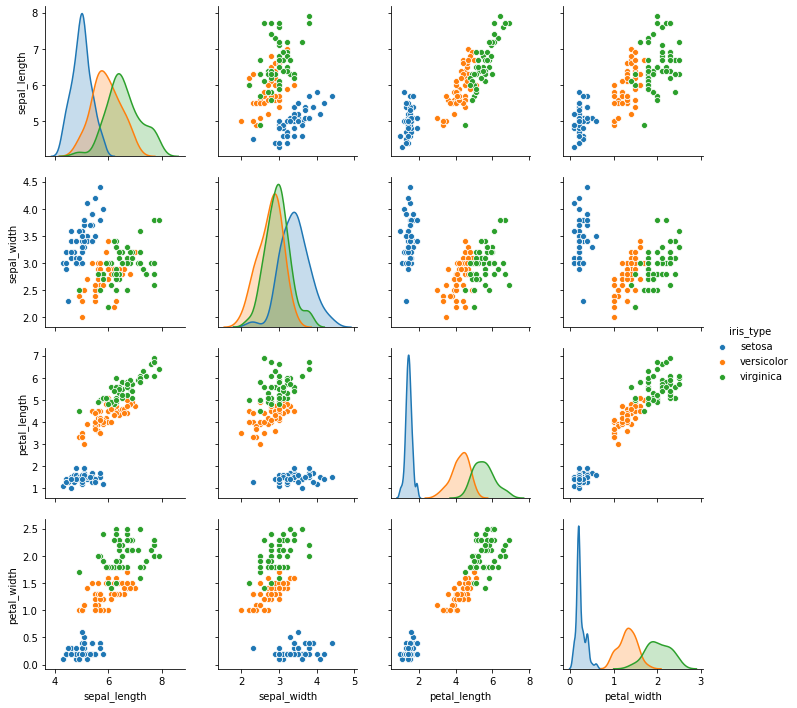

In [7]:
sns.pairplot(iris_df[['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'iris_type']],
             hue = 'iris_type')
plt.show()

### Let's look more closely at Setosa {0,1} and Sepal Length

Text(0.5, 21.70625000000002, 'Sepal Length')

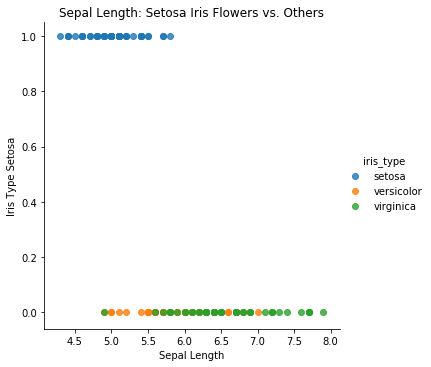

In [8]:
x_var = 'sepal_length'
y_var = 'iris_type_setosa'
color_var = 'iris_type'
title_str = 'Sepal Length: Setosa Iris Flowers vs. Others'
x_axis_str = 'Sepal Length'
y_axis_str = 'Iris Type Setosa'


sns.lmplot(x_var, y_var, hue = color_var, data = iris_df, fit_reg = False)
plt.title(title_str)
plt.ylabel(y_axis_str)
plt.xlabel(x_axis_str)

# <font color='blue'>2) Split dataset into train/test for cross validation</font>

### Train Test Split

In [9]:
train_df, test_df = train_test_split(iris_df, test_size = 0.2, random_state = 2020)

### Create X and Y Variables ... Notice Constant Added to X for Regression Intercept

##### $log_{b} \frac{p}{(1 - p)}$ Setosa = $\beta_{0}$ + $\beta_{1}$ $SepalLength_{i}$ + $\epsilon_{i}$

##### i.e. log odds of Setosa [0,1] are a function of intercept plus beta coefficient X Sepal Length plus error term

In [10]:
y_col = 'iris_type_setosa'
x_cols = ['sepal_length']
train_x = sm.add_constant(train_df[x_cols]) 
test_x = sm.add_constant(test_df[x_cols])
train_y = train_df[[y_col]]
test_y = test_df[[y_col]]

In [11]:
train_x.head()

,const,sepal_length
105,1.0,7.6
40,1.0,5.0
7,1.0,5.0
17,1.0,5.1
115,1.0,6.4


# <font color='blue'>3) Fit a binary logistic regression</font>

### Fit on Training Set

In [12]:
log_reg = sm.Logit(train_y, train_x).fit()

Optimization terminated successfully.
         Current function value: 0.236027
         Iterations 9


### Print Regression Output Summary

In [13]:
print(log_reg.summary())

                           Logit Regression Results                           
Dep. Variable:       iris_type_setosa   No. Observations:                  120
Model:                          Logit   Df Residuals:                      118
Method:                           MLE   Df Model:                            1
Date:                Thu, 15 Oct 2020   Pseudo R-squ.:                  0.6292
Time:                        22:02:03   Log-Likelihood:                -28.323
converged:                       True   LL-Null:                       -76.382
Covariance Type:            nonrobust   LLR p-value:                 1.083e-22
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           29.2346      5.853      4.994      0.000      17.762      40.707
sepal_length    -5.4065      1.077     -5.021      0.000      -7.517      -3.296


# <font color='blue'>4) Assess prediction accuracy on test set</font>

### Predict on Test Set and Evaluate Results

In [14]:
test_df['pred_values'] = log_reg.predict(test_x)

In [15]:
test_df.head()

,sepal_length,sepal_width,petal_length,petal_width,iris_type,iris_type_setosa,iris_type_versicolor,iris_type_virginica,pred_values
104,6.5,3.0,5.8,2.2,virginica,0,0,1,0.002710
8,4.4,2.9,1.4,0.2,setosa,1,0,0,0.995704
61,5.9,3.0,4.2,1.5,versicolor,0,1,0,0.065128
54,6.5,2.8,4.6,1.5,versicolor,0,1,0,0.002710
78,6.0,2.9,4.5,1.5,versicolor,0,1,0,0.038989


(array([15.,  1.,  1.,  1.,  0.,  1.,  0.,  1.,  1.,  9.]),
 array([9.20853615e-04, 1.00399168e-01, 1.99877482e-01, 2.99355796e-01,
        3.98834110e-01, 4.98312424e-01, 5.97790738e-01, 6.97269052e-01,
        7.96747366e-01, 8.96225680e-01, 9.95703994e-01]),
 <a list of 10 Patch objects>)

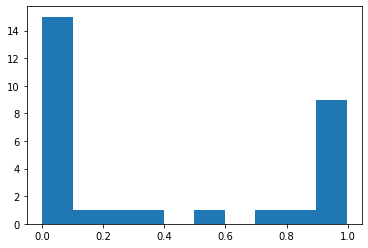

In [16]:
plt.hist(test_df['pred_values'])

### Plot Predicted vs. Actual
#### <font color='orange'>(already done for you)</font>

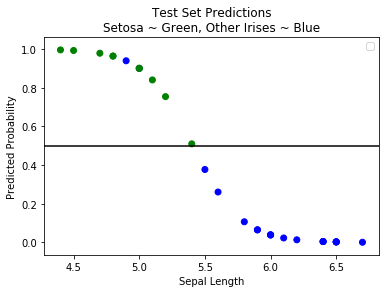

In [17]:
fix, ax = plt.subplots()
color_dict = {0 : 'blue', 1 : 'green'}
ax.scatter(test_df['sepal_length'], test_df['pred_values'], c = test_df['iris_type_setosa'].apply(lambda x: color_dict[x]))
plt.axhline(y = 0.5, color = 'black', linestyle = '-')
plt.title('Test Set Predictions\nSetosa ~ Green, Other Irises ~ Blue')
plt.ylabel('Predicted Probability')
plt.xlabel('Sepal Length')
ax.legend(['blue', 'green'], ['Other Iris', 'Setosa'])
plt.show()

### Convert Predicted Probabilities to Binary, Calculate Accuracy

In [19]:
test_df['pred_binary'] = [int(np.round(x, 0)) for x in test_df['pred_values']]

In [20]:
test_df.head()

,sepal_length,sepal_width,petal_length,petal_width,iris_type,iris_type_setosa,iris_type_versicolor,iris_type_virginica,pred_values,pred_binary
104,6.5,3.0,5.8,2.2,virginica,0,0,1,0.002710,0
8,4.4,2.9,1.4,0.2,setosa,1,0,0,0.995704,1
61,5.9,3.0,4.2,1.5,versicolor,0,1,0,0.065128,0
54,6.5,2.8,4.6,1.5,versicolor,0,1,0,0.002710,0
78,6.0,2.9,4.5,1.5,versicolor,0,1,0,0.038989,0


### Look at first 5 rows of predicted values, predicted binary value, and actual iris_type_setosa

In [10]:
use_vars = ['pred_values', 'pred_binary', 'iris_type_setosa']


### Calculate and print accuracy

In [21]:
correct = test_df[test_df.pred_binary == test_df.iris_type_setosa].shape[0]
total = test_df.shape[0]
accuracy = correct / total
print(f'Test Set Accuracy: {np.round(accuracy * 100, 2)}%')

Test Set Accuracy: 93.33%


# <font color='blue'>5) Prove your theoretical understanding - predict using only the coefficients</font>

### Let's look at the regression summary again

In [22]:
log_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:       iris_type_setosa   No. Observations:                  120
Model:                          Logit   Df Residuals:                      118
Method:                           MLE   Df Model:                            1
Date:                Thu, 15 Oct 2020   Pseudo R-squ.:                  0.6292
Time:                        22:08:39   Log-Likelihood:                -28.323
converged:                       True   LL-Null:                       -76.382
Covariance Type:            nonrobust   LLR p-value:                 1.083e-22
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           29.2346      5.853      4.994      0.000      17.762      40.707
sepal_length    -5.4065      1.077     -5.021      0.000      -7.517      -3.296
================================================================================
"""

### Recall our functional form we defined above:
##### $log_{b} \frac{p}{(1 - p)}$ Setosa = $\beta_{0}$ + $\beta_{1}$ $SepalLength_{i}$ + $\epsilon_{i}$

### Now we have $\beta_{0}$ and $\beta_{1}$ estimates
##### Setosa Log Odds = 29.2346 + { -5.4065  X SepalLength}  + $\epsilon_{i}$

### Write a Function that Predicts Probabilities Using Coefficients Only

In [23]:
coefficient_dict = extract_logreg_coefficients(log_reg)
b0 = coefficient_dict.get('const')
b1 = coefficient_dict.get('sepal_length')

In [25]:
def predict_setosa_prob(sepal_length, b0 = b0, b1 = b1):
    """
    Predict Setosa probability based on sepal length given an intercept and beta coefficient
    Args:
        sepal_length (float): float representing sepal length independent variable
        b0 (float): float representing regression intercept term
        b1 (float): float representing regression beta coefficient for sepal length
    Returns:
        float
    """
    logit = b0 + (b1 * sepal_length)
    probability = 1 / (1 + np.exp(-logit))
    return probability

### Compare to statsmodels API Prediction to Ensure it Works Correctly
#### <font color='orange'>(already done for you)</font>

In [26]:
function_predictions = [predict_setosa_prob(x) for x in test_df['sepal_length']]
api_predictions = log_reg.predict(sm.add_constant(test_df[['sepal_length']]))
prediction_df = pd.DataFrame({'function_prob' : function_predictions,
                              'api_prob' : api_predictions})
prediction_df.head()

,function_prob,api_prob
104,0.002711,0.002710
8,0.995705,0.995704
61,0.065147,0.065128
54,0.002711,0.002710
78,0.039000,0.038989


### The function works correctly. Differences in the fourth decimal place are due to rounding in the statsmodel package.